## 线性回归

算法推导过程中已经给出了求解方法，基于最小二乘法直接求解，但这并不是机器学习的思想，由此引入了梯度下降方法。本次实验课重点讲解其中每一步流程与实验对比分析。

### 主要内容：
* 线性回归方程实现
* 梯度下降效果
* 对比不同梯度下降策略
* 建模曲线分析
* 过拟合与欠拟合
* 正则化的作用
* 提前停止策略

In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 回归方程：
当做是一个巧合就可以了，机器学习中核心的思想是迭代更新

![title](./img/线性回归/1.png)

In [2]:
import numpy as np
X = 2*np.random.rand(100,1)
y = 4+ 3*X +np.random.randn(100,1)

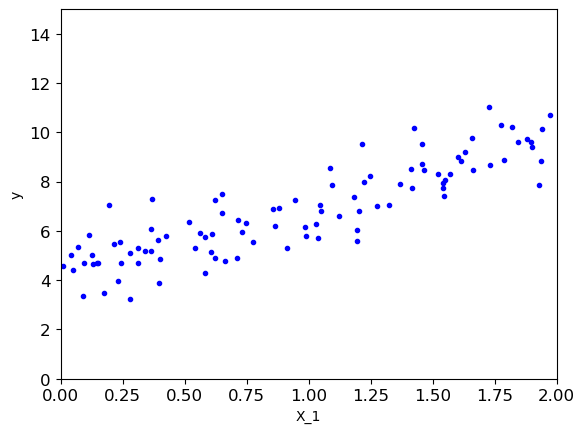

In [3]:
plt.plot(X,y,'b.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.axis([0,2,0,15])
plt.show()

In [4]:
X_b = np.c_[np.ones((100,1)),X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [6]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

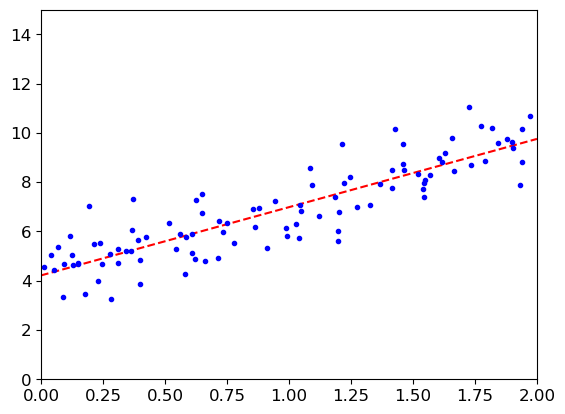

In [7]:
plt.plot(X_new,y_predict,'r--')
plt.plot(X,y,'b.')
plt.axis([0,2,0,15])
plt.show()

### sklearn api文档：
不用背，用到的时候现查完全够用的。
https://scikit-learn.org/stable/modules/classes.html

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print (lin_reg.coef_)
print (lin_reg.intercept_)

[[2.77011339]]
[4.21509616]


### 梯度下降
核心解决方案，不光在线性回归中能用上，还有其他算法中能用上，比如神经网络

![title](./img/线性回归/2.png)

#### 问题：步长太小

![title](./img/线性回归/3.png)

#### 问题：步长太大

![title](./img/线性回归/4.png)

![title](./img/线性回归/5.png)

学习率应当尽可能小，随着迭代的进行应当越来越小。

### 标准化的作用:
- 拿到数据之后基本上都需要做一次标准化操作

![title](./img/线性回归/6.png)

### 批量梯度下降计算公式

![title](./img/线性回归/7.png)

### 批量梯度下降

In [9]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)
for iteration in range(n_iterations):
    gradients = 2/m* X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta*gradients

In [10]:
theta

array([[4.21509616],
       [2.77011339]])

In [11]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [12]:
theta_path_bgd = []
def plot_gradient_descent(theta,eta,theta_path = None):
    m = len(X_b)
    plt.plot(X,y,'b.')
    n_iterations = 1000
    for iteration in range(n_iterations):
        y_predict = X_new_b.dot(theta)
        plt.plot(X_new,y_predict,'b-')
        gradients = 2/m* X_b.T.dot(X_b.dot(theta)-y)
        theta = theta - eta*gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel('X_1')
    plt.axis([0,2,0,15])
    plt.title('eta = {}'.format(eta))

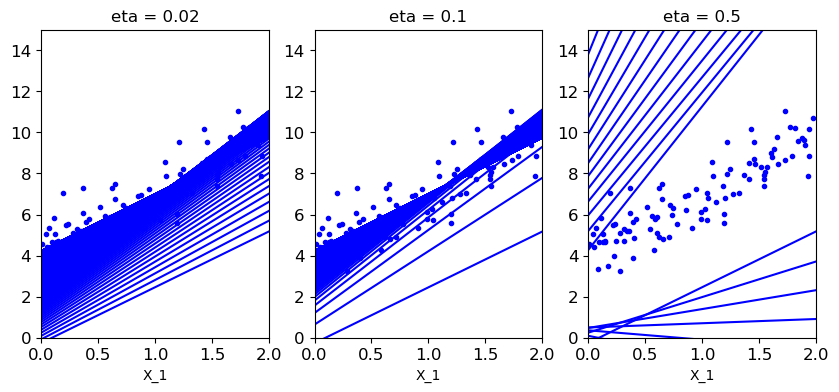

In [13]:
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131)
plot_gradient_descent(theta,eta = 0.02)
plt.subplot(132)
plot_gradient_descent(theta,eta = 0.1,theta_path=theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta,eta = 0.5)
plt.show()


### 随机梯度下降

![title](./img/线性回归/8.png)

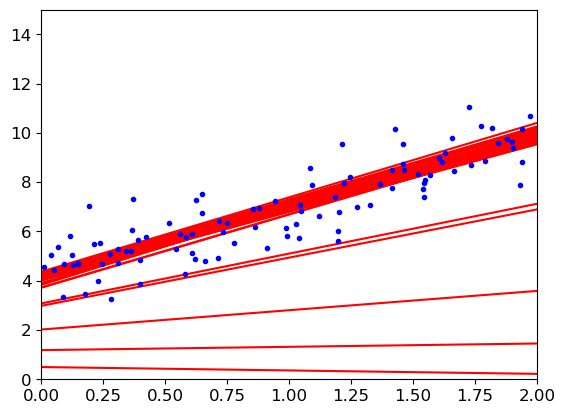

In [14]:
theta_path_sgd=[]
m = len(X_b)
np.random.seed(42)
n_epochs = 50

t0 = 5
t1 = 50

def learning_schedule(t):
    return t0/(t1+t)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch < 10 and i<10:
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new,y_predict,'r-')
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2* xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta-eta*gradients
        theta_path_sgd.append(theta)
        
plt.plot(X,y,'b.')
plt.axis([0,2,0,15])   
plt.show()





### MiniBatch梯度下降

In [15]:
theta_path_mgd=[]
n_epochs = 50
minibatch = 16
theta = np.random.randn(2,1)
t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)
np.random.seed(42)
t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0,m,minibatch):
        t+=1
        xi = X_b_shuffled[i:i+minibatch]
        yi = y_shuffled[i:i+minibatch]
        gradients = 2/minibatch* xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(t)
        theta = theta-eta*gradients
        theta_path_mgd.append(theta)

In [16]:
theta

array([[4.25490685],
       [2.80388784]])

### 3种策略的对比实验

In [17]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

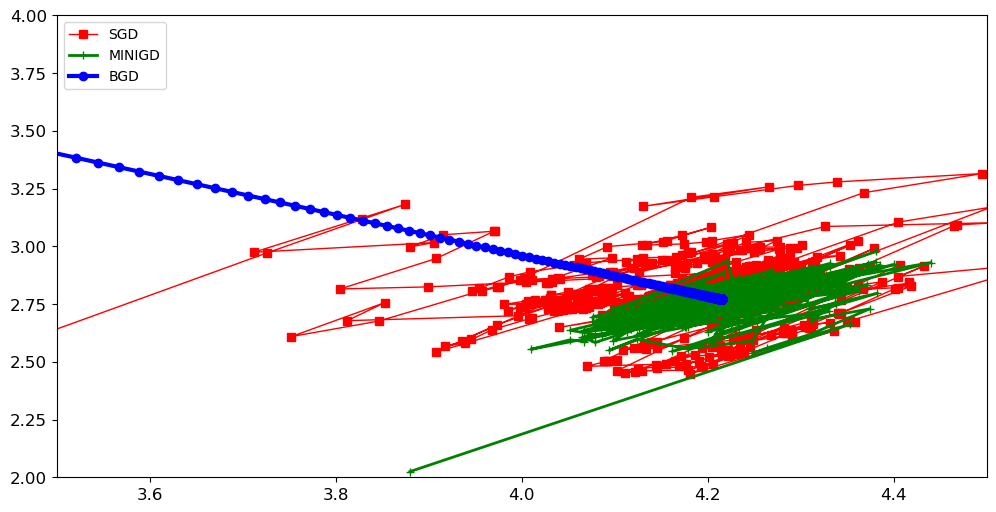

In [18]:
plt.figure(figsize=(12,6))
plt.plot(theta_path_sgd[:,0],theta_path_sgd[:,1],'r-s',linewidth=1,label='SGD')
plt.plot(theta_path_mgd[:,0],theta_path_mgd[:,1],'g-+',linewidth=2,label='MINIGD')
plt.plot(theta_path_bgd[:,0],theta_path_bgd[:,1],'b-o',linewidth=3,label='BGD')
plt.legend(loc='upper left')
plt.axis([3.5,4.5,2.0,4.0])
plt.show()


实际当中用minibatch比较多，一般情况下选择batch数量应当越大越好。

### 多项式回归

In [19]:
m = 100
X = 6*np.random.rand(m,1) - 3
y = 0.5*X**2+X+np.random.randn(m,1)

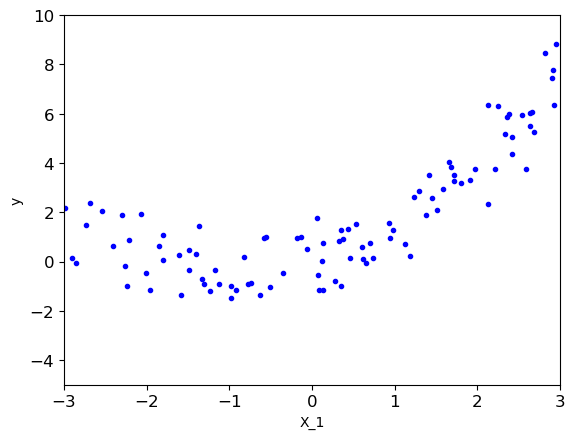

In [20]:
plt.plot(X,y,'b.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.axis([-3,3,-5,10])
plt.show()

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2,include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.38942838])

In [22]:
X_poly[0]

array([2.38942838, 5.709368  ])

In [23]:
2.82919615 ** 2

8.004350855174822

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
print (lin_reg.coef_)
print (lin_reg.intercept_)

[[0.95038538 0.52577032]]
[-0.0264767]


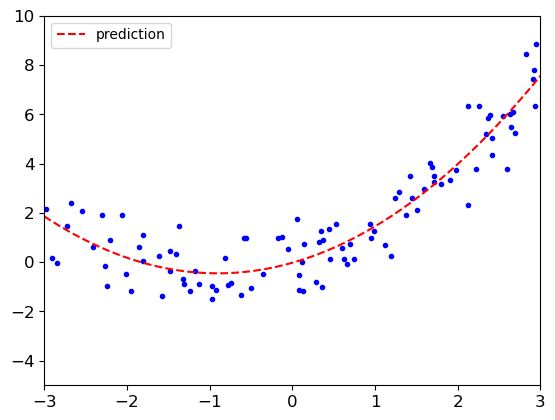

In [25]:
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X,y,'b.')
plt.plot(X_new,y_new,'r--',label='prediction')
plt.axis([-3,3,-5,10])
plt.legend()
plt.show()

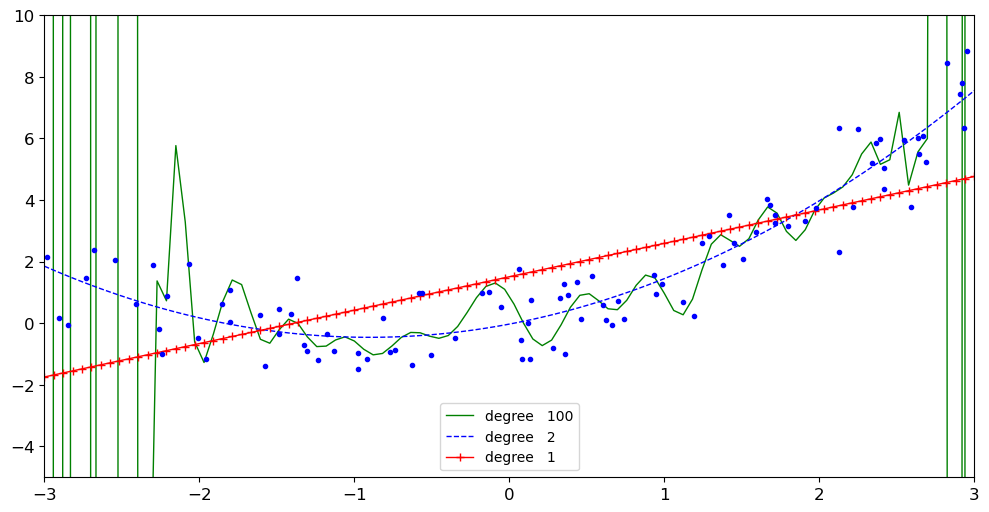

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
plt.figure(figsize=(12,6))
for style,width,degree in (('g-',1,100),('b--',1,2),('r-+',1,1)):
    poly_features = PolynomialFeatures(degree = degree,include_bias = False)
    std = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_reg = Pipeline([('poly_features',poly_features),
             ('StandardScaler',std),
             ('lin_reg',lin_reg)])
    polynomial_reg.fit(X,y)
    y_new_2 = polynomial_reg.predict(X_new)
    plt.plot(X_new,y_new_2,style,label = 'degree   '+str(degree),linewidth = width)
plt.plot(X,y,'b.')
plt.axis([-3,3,-5,10])
plt.legend()
plt.show()

特征变换的越复杂，得到的结果过拟合风险越高，不建议做的特别复杂。

### 数据样本数量对结果的影响

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model,X,y):
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2,random_state=100)
    train_errors,val_errors = [],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict[:m]))
        val_errors.append(mean_squared_error(y_val,y_val_predict))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth = 2,label = 'train_error')
    plt.plot(np.sqrt(val_errors),'b-',linewidth = 3,label = 'val_error')
    plt.xlabel('Trainsing set size')
    plt.ylabel('RMSE')
    plt.legend()

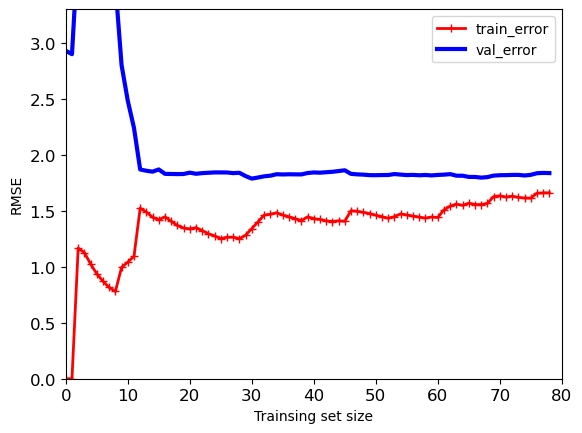

In [28]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X,y)
plt.axis([0,80,0,3.3])
plt.show()

数据量越少，训练集的效果会越好，但是实际测试效果很一般。实际做模型的时候需要参考测试集和验证集的效果。

### 多项式回归的过拟合风险

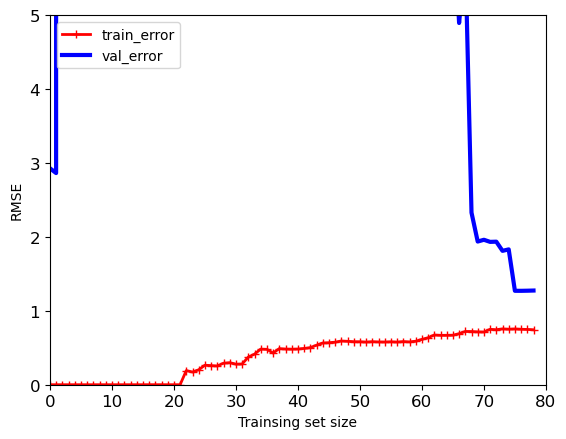

In [29]:
polynomial_reg = Pipeline([('poly_features',PolynomialFeatures(degree = 25,include_bias = False)), ('lin_reg',LinearRegression())])
plot_learning_curves(polynomial_reg,X,y)
plt.axis([0,80,0,5])
plt.show()

越复杂越过拟合

### 正则化

对权重参数进行惩罚，让权重参数尽可能平滑一些，有两种不同的方法来进行正则化惩罚:

![title](./img/线性回归/9.png)

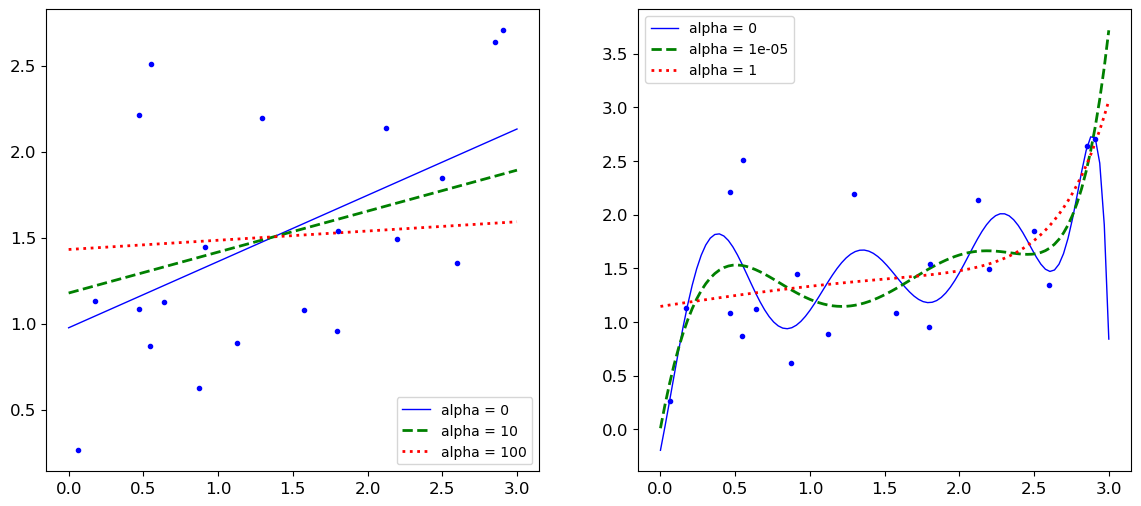

In [30]:
from sklearn.linear_model import Ridge
np.random.seed(42)
m = 20
X = 3*np.random.rand(m,1)
y = 0.5 * X +np.random.randn(m,1)/1.5 +1
X_new = np.linspace(0,3,100).reshape(100,1)

def plot_model(model_calss,polynomial,alphas,**model_kargs):
    for alpha,style in zip(alphas,('b-','g--','r:')):
        model = model_calss(alpha,**model_kargs)
        if polynomial:
            model = Pipeline([('poly_features',PolynomialFeatures(degree =10,include_bias = False)),
             ('StandardScaler',StandardScaler()),
             ('lin_reg',model)])
        model.fit(X,y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new,y_new_regul,style,linewidth = lw,label = 'alpha = {}'.format(alpha))
    plt.plot(X,y,'b.',linewidth =3)
    plt.legend()

plt.figure(figsize=(14,6))
plt.subplot(121)
plot_model(Ridge,polynomial=False,alphas = (0,10,100))
plt.subplot(122)
plot_model(Ridge,polynomial=True,alphas = (0,10**-5,1))
plt.show()

惩罚力度越大，alpha值越大的时候，得到的决策方程越平稳。

![title](./img/线性回归/10.png)

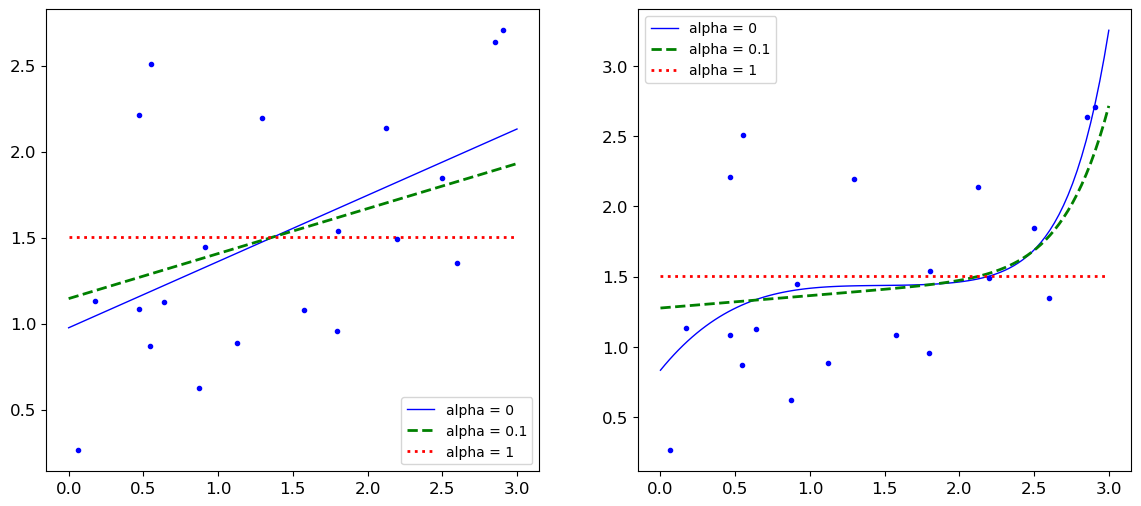

In [31]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(14,6))
plt.subplot(121)
plot_model(Lasso,polynomial=False,alphas = (0,0.1,1))
plt.subplot(122)
plot_model(Lasso,polynomial=True,alphas = (0,10**-1,1))
plt.show()

多做实验，得出结果！！！